In [64]:
# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sns.set_style("whitegrid")
np.random.seed(0)

In [65]:
df = pd.read_csv('test_data.csv')
df.head()

,t,l
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [66]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [67]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import codecs


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [68]:
MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [69]:
label_names = ["l"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['t'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)


In [70]:
from sklearn.utils import shuffle 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

raw_docs_train = train_df['t'].tolist()
raw_docs_test = test_df['t'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 2001/2001 [00:00<00:00, 5955.09it/s]


tokenizing input data...
dictionary size:  2306


In [71]:
# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
# from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

## Glove

In [13]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [14]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('/content/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


2196018it [03:59, 9184.49it/s]

found 2196016 word vectors


In [15]:
#embedding matrix

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 42


### LSTM

In [72]:
from keras.layers import BatchNormalization
import tensorflow as tf

def create_lstm_model():
  model_lstm = tf.keras.Sequential()
  model_lstm.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
  # model.add(SpatialDropout1D(0.7))
  model_lstm.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_lstm.add(Dense(128,activation='relu'))
  model_lstm.add(Dense(77, activation='softmax'))
  model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
  return model_lstm


In [73]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_lstm_glove = create_lstm_model()

model_lstm_glove.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 300)           756600    
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 77)                9933      
                                                                 
Total params: 1,238,725
Trainable params: 482,125
Non-trainable params: 756,600
_________________________________________________________________


In [74]:
# from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_lstm_glove.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [75]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_lstm_glove.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 20s 618ms/step - loss: 4.3068 - accuracy: 0.0230 - val_loss: 4.2103 - val_accuracy: 0.0362
Epoch 2/40
22/22 [==============================] - 13s 580ms/step - loss: 4.1109 - accuracy: 0.0666 - val_loss: 3.8688 - val_accuracy: 0.1125
Epoch 3/40
22/22 [==============================] - 13s 584ms/step - loss: 3.7270 - accuracy: 0.1248 - val_loss: 3.3326 - val_accuracy: 0.2041
Epoch 4/40
22/22 [==============================] - 13s 576ms/step - loss: 3.2574 - accuracy: 0.2085 - val_loss: 2.7878 - val_accuracy: 0.3099
Epoch 5/40
22/22 [==============================] - 13s 586ms/step - loss: 2.8470 - accuracy: 0.2817 - val_loss: 2.3588 - val_accuracy: 0.3986
Epoch 6/40
22/22 [==============================] - 13s 589ms/step - loss: 2.5555 - accuracy: 0.3464 - val_loss: 2.1264 - val_accuracy: 0.4436
Epoch 7/40
22/22 [==============================] - 13s 592ms/step - loss: 2.3242 - accuracy: 0.3917 - val_loss: 1.9160 - val_accuracy: 0.4952
Epoch 8/40

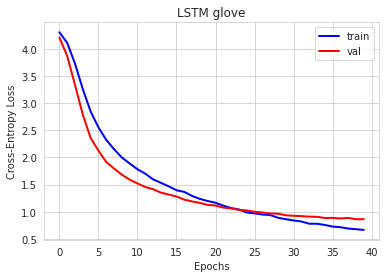

In [76]:
#generate plots
plt.figure()
plt.plot(history_glove.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

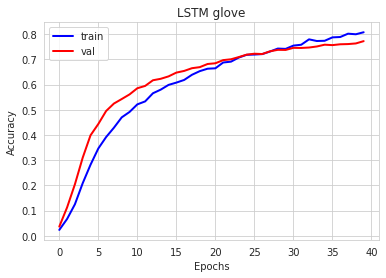

In [77]:
plt.figure()
plt.plot(history_glove.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [78]:
predictions = model_lstm_glove.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,59,59
2545,15,15
8697,5,5
...,...,...
2769,66,66
5065,26,26
8287,17,76
7986,58,58


In [79]:
import sklearn

print("Accuracy With glove LSTM:")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With glove LSTM:
0.776111944027986


### CNN

In [80]:
#CNN architecture

num_filters = 64 

def create_cnn_model():
  model_cnn = Sequential()
  model_cnn.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(MaxPooling1D(2))
  model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_cnn.add(GlobalMaxPooling1D())
  model_cnn.add(Dropout(0.5))
  model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
  model_cnn.add(Dense(77, activation='softmax'))

  adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  return model_cnn


In [81]:
#CNN architecture
model_cnn_glove = create_cnn_model()
model_cnn_glove.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 300)           756600    
                                                                 
 conv1d_6 (Conv1D)           (None, 20, 64)            134464    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 10, 64)            28736     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [82]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_cnn_glove.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [83]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_cnn_glove.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 3s 126ms/step - loss: 4.3480 - accuracy: 0.0168 - val_loss: 4.3295 - val_accuracy: 0.0296
Epoch 2/40
22/22 [==============================] - 2s 113ms/step - loss: 4.2907 - accuracy: 0.0248 - val_loss: 4.2423 - val_accuracy: 0.0479
Epoch 3/40
22/22 [==============================] - 3s 118ms/step - loss: 4.1584 - accuracy: 0.0550 - val_loss: 4.0499 - val_accuracy: 0.0866
Epoch 4/40
22/22 [==============================] - 3s 116ms/step - loss: 3.9186 - accuracy: 0.0930 - val_loss: 3.7515 - val_accuracy: 0.1154
Epoch 5/40
22/22 [==============================] - 2s 112ms/step - loss: 3.5904 - accuracy: 0.1357 - val_loss: 3.3581 - val_accuracy: 0.1928
Epoch 6/40
22/22 [==============================] - 2s 111ms/step - loss: 3.2432 - accuracy: 0.1951 - val_loss: 3.0047 - val_accuracy: 0.2524
Epoch 7/40
22/22 [==============================] - 2s 112ms/step - loss: 2.9377 - accuracy: 0.2442 - val_loss: 2.7291 - val_accuracy: 0.3232
Epoch 8/40
22/22 

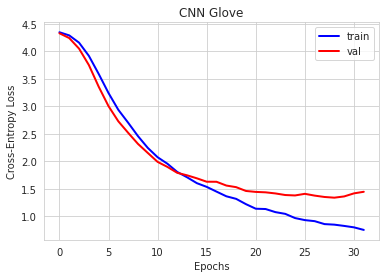

In [84]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN Glove')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

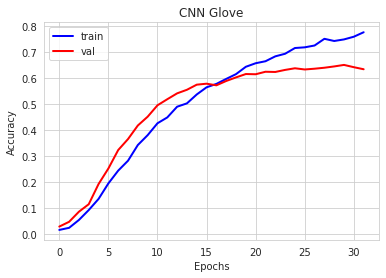

In [85]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN Glove')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [86]:
predictions = model_cnn_glove.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,11,25
8601,71,59
2545,63,15
8697,5,5
...,...,...
2769,66,66
5065,26,26
8287,76,76
7986,58,58


In [87]:
import sklearn

print("Accuracy With glove CNN :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With glove CNN :
0.6291854072963519


### CNN + LSTM

In [88]:
def create_cnn_lstm_model():
  model_mix = Sequential()
  model_mix.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
  model_mix.add(Dropout(0.2))
  model_mix.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model_mix.add(MaxPooling1D(pool_size=4))
  model_mix.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
  model_mix.add(Dense(128,activation='relu'))
  model_mix.add(Dense(77, activation='softmax'))
  model_mix.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model_mix


In [89]:
model_mix_glove = create_cnn_lstm_model()

In [90]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_mix_glove.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 11s 234ms/step - loss: 4.3211 - accuracy: 0.0187 - val_loss: 4.2686 - val_accuracy: 0.0171
Epoch 2/40
22/22 [==============================] - 4s 201ms/step - loss: 4.2262 - accuracy: 0.0352 - val_loss: 4.0959 - val_accuracy: 0.0879
Epoch 3/40
22/22 [==============================] - 4s 202ms/step - loss: 3.9767 - accuracy: 0.0773 - val_loss: 3.6641 - val_accuracy: 0.1133
Epoch 4/40
22/22 [==============================] - 4s 204ms/step - loss: 3.5588 - accuracy: 0.1269 - val_loss: 3.2053 - val_accuracy: 0.1816
Epoch 5/40
22/22 [==============================] - 4s 205ms/step - loss: 3.1462 - accuracy: 0.1925 - val_loss: 2.7266 - val_accuracy: 0.2782
Epoch 6/40
22/22 [==============================] - 4s 204ms/step - loss: 2.8035 - accuracy: 0.2632 - val_loss: 2.4096 - val_accuracy: 0.3557
Epoch 7/40
22/22 [==============================] - 4s 203ms/step - loss: 2.5278 - accuracy: 0.3203 - val_loss: 2.1802 - val_accuracy: 0.4023
Epoch 8/40
22/22

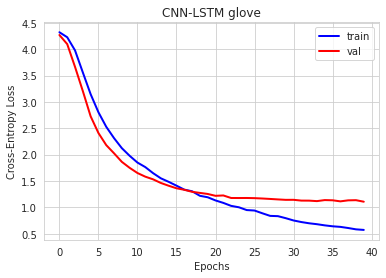

In [91]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

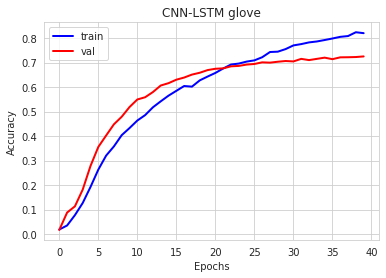

In [92]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM glove')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [93]:
predictions = model_mix_glove.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,59,59
2545,34,15
8697,5,5
...,...,...
2769,61,66
5065,26,26
8287,17,76
7986,58,58


In [94]:
import sklearn

print("Accuracy With glove CNN-LSTM :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy With glove CNN-LSTM :
0.7286356821589205


## Without word embedding
**texte en gras**

### LSTM

In [95]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_without_lstm = tf.keras.Sequential()

model_without_lstm.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, trainable=False))
model_without_lstm.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
model_without_lstm.add(Dense(128,activation='relu'))
model_without_lstm.add(Dense(77, activation='softmax'))
model_without_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_without_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 300)           756600    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 77)                9933      
                                                                 
Total params: 1,238,725
Trainable params: 482,125
Non-trainable params: 756,600
_________________________________________________________________


In [96]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_without_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [97]:
# from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_without_lstm.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [98]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_without_lstm.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 20s 613ms/step - loss: 4.3350 - accuracy: 0.0193 - val_loss: 4.3253 - val_accuracy: 0.0292
Epoch 2/40
22/22 [==============================] - 13s 582ms/step - loss: 4.3037 - accuracy: 0.0325 - val_loss: 4.2940 - val_accuracy: 0.0587
Epoch 3/40
22/22 [==============================] - 13s 590ms/step - loss: 4.2333 - accuracy: 0.0473 - val_loss: 4.1736 - val_accuracy: 0.0508
Epoch 4/40
22/22 [==============================] - 13s 583ms/step - loss: 4.1233 - accuracy: 0.0596 - val_loss: 4.0323 - val_accuracy: 0.0621
Epoch 5/40
22/22 [==============================] - 13s 595ms/step - loss: 3.9172 - accuracy: 0.0768 - val_loss: 3.6492 - val_accuracy: 0.1245
Epoch 6/40
22/22 [==============================] - 13s 588ms/step - loss: 3.6496 - accuracy: 0.1061 - val_loss: 3.3333 - val_accuracy: 0.1612
Epoch 7/40
22/22 [==============================] - 13s 592ms/step - loss: 3.4534 - accuracy: 0.1403 - val_loss: 3.0918 - val_accuracy: 0.2374
Epoch 8/40

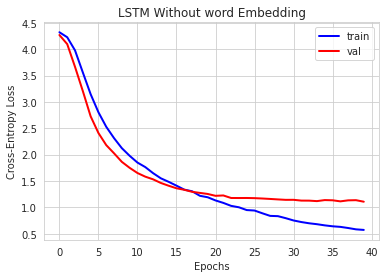

In [99]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM Without word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

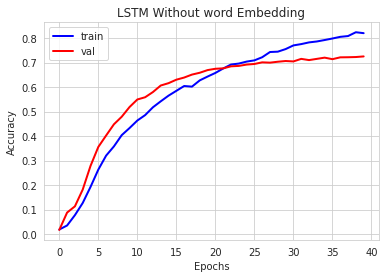

In [100]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM Without word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [101]:
predictions = model_without_lstm.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,59,59
2545,15,15
8697,5,5
...,...,...
2769,35,66
5065,26,26
8287,17,76
7986,58,58


In [102]:
import sklearn

print("Accuracy Without word Embedding LSTM:")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy Without word Embedding LSTM:
0.6871564217891054


### CNN

In [103]:
num_filters = 64 

In [104]:
#CNN architecture
model_cnn = Sequential()
model_cnn.add(Embedding(nb_words, embed_dim, input_length=max_seq_len, trainable=False))
model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model_cnn.add(Dense(77, activation='softmax'))

adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_cnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 20, 300)           756600    
                                                                 
 conv1d_9 (Conv1D)           (None, 20, 64)            134464    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 64)            28736     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_6 (Dropout)         (None, 64)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [105]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_cnn.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [106]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_cnn.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 3s 125ms/step - loss: 4.3444 - accuracy: 0.0137 - val_loss: 4.3401 - val_accuracy: 0.0167
Epoch 2/40
22/22 [==============================] - 2s 113ms/step - loss: 4.3292 - accuracy: 0.0216 - val_loss: 4.3205 - val_accuracy: 0.0133
Epoch 3/40
22/22 [==============================] - 2s 112ms/step - loss: 4.2954 - accuracy: 0.0230 - val_loss: 4.2703 - val_accuracy: 0.0200
Epoch 4/40
22/22 [==============================] - 2s 114ms/step - loss: 4.2081 - accuracy: 0.0298 - val_loss: 4.1506 - val_accuracy: 0.0421
Epoch 5/40
22/22 [==============================] - 2s 113ms/step - loss: 4.0426 - accuracy: 0.0530 - val_loss: 3.9216 - val_accuracy: 0.0725
Epoch 6/40
22/22 [==============================] - 2s 114ms/step - loss: 3.7811 - accuracy: 0.0882 - val_loss: 3.6291 - val_accuracy: 0.1075
Epoch 7/40
22/22 [==============================] - 2s 113ms/step - loss: 3.5041 - accuracy: 0.1061 - val_loss: 3.3133 - val_accuracy: 0.1720
Epoch 8/40
22/22 

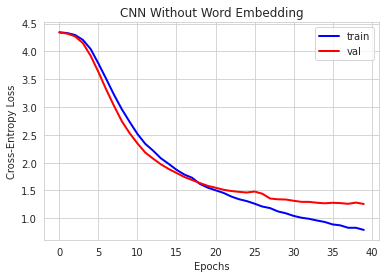

In [107]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

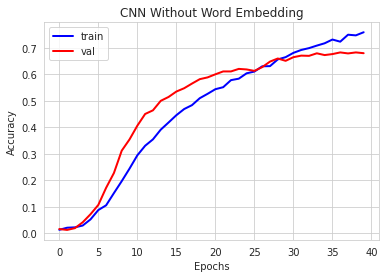

In [108]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [109]:
predictions = model_cnn.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,62,59
2545,34,15
8697,5,5
...,...,...
2769,5,66
5065,26,26
8287,17,76
7986,58,58


In [110]:
import sklearn

print("Accuracy Without word embedding CNN :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy Without word embedding CNN :
0.6936531734132934


### CNN + LSTM

In [111]:
model_mix_without_w_e = Sequential()
model_mix_without_w_e.add(Embedding(nb_words, embed_dim,  input_length=max_seq_len, trainable=False))
model_mix_without_w_e.add(Dropout(0.2))
model_mix_without_w_e.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model_mix_without_w_e.add(MaxPooling1D(pool_size=4))
model_mix_without_w_e.add(Bidirectional(LSTM(128, dropout=0.7, recurrent_dropout=0.7)))
model_mix_without_w_e.add(Dense(128,activation='relu'))
model_mix_without_w_e.add(Dense(77, activation='softmax'))
model_mix_without_w_e.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  


In [112]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model_mix_without_w_e.fit(word_seq_train, y_train, batch_size=256, epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 11s 224ms/step - loss: 4.3376 - accuracy: 0.0155 - val_loss: 4.3236 - val_accuracy: 0.0162
Epoch 2/40
22/22 [==============================] - 4s 200ms/step - loss: 4.2990 - accuracy: 0.0195 - val_loss: 4.2646 - val_accuracy: 0.0221
Epoch 3/40
22/22 [==============================] - 4s 199ms/step - loss: 4.2081 - accuracy: 0.0284 - val_loss: 4.1227 - val_accuracy: 0.0371
Epoch 4/40
22/22 [==============================] - 4s 198ms/step - loss: 4.0416 - accuracy: 0.0398 - val_loss: 3.9081 - val_accuracy: 0.0496
Epoch 5/40
22/22 [==============================] - 4s 205ms/step - loss: 3.8209 - accuracy: 0.0548 - val_loss: 3.6527 - val_accuracy: 0.0916
Epoch 6/40
22/22 [==============================] - 4s 200ms/step - loss: 3.5710 - accuracy: 0.0946 - val_loss: 3.3298 - val_accuracy: 0.1458
Epoch 7/40
22/22 [==============================] - 4s 197ms/step - loss: 3.2709 - accuracy: 0.1369 - val_loss: 3.0016 - val_accuracy: 0.1974
Epoch 8/40
22/22

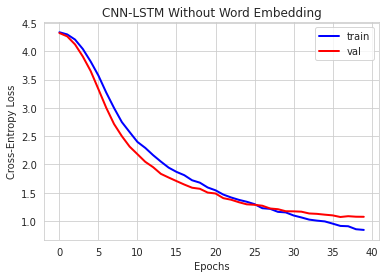

In [113]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

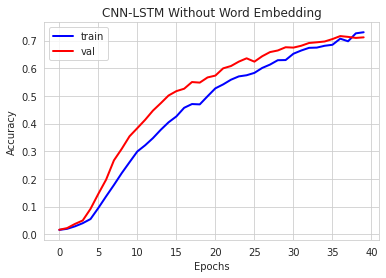

In [114]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN-LSTM Without Word Embedding')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [115]:
predictions = model_mix_without_w_e.predict(word_seq_test)
list_ = []
for i in range(len(predictions)):
  a = predictions[i]
  list_.append(np.where(a == a.max())[0][0] )


sample= test_df
sample['pred']= list_ 
sample[['pred', "l"]]

,pred,l
6883,21,21
5836,14,25
8601,59,59
2545,15,15
8697,5,5
...,...,...
2769,5,66
5065,26,26
8287,17,76
7986,58,58


In [116]:
import sklearn

print("Accuracy Without Word Embedding CNN-LSTM :")
print(sklearn.metrics.accuracy_score(sample.l, sample.pred))

Accuracy Without Word Embedding CNN-LSTM :
0.7126436781609196
